# MAC0460 / MAC5832 (2020)
<hr>

## EP3: Linear regression + gradient descent

### Topics explored:

- implementation and test of the *batch gradient descent* algorithm for solving the linear regression problem 
- understanding cost functions and the core idea of gradient descent
- comparison of both solutions (the analytic and the gradient descent based ones)

### The evaluation will consider 
- correctitude of the algorithms
- appropriateness of the answers
- Code
    - do not change the prototype of the function
    - efficiency (you should avoid unnecessary loops; use matrix/vector computation with NumPy wherever appropriate)
    - cleanliness (do not leave any commented code or useless variables)
- File format: Complete and submit this notebook. **PLEASE do no change the file name.**
<hr>

## Linear Regression

See EP2 to recall some terms and concepts.
See also the reference materials pointed in class log notes.


## Gradient descent

Gradient descent is a technique used to find the minimum of a function. Here we will use it to compute the minimum of the cost function $J:\mathbb{R}^{1+d} \rightarrow \mathbb{R}$:

\begin{equation}
J(\mathbf{w}) = \frac{1}{N}\sum_{i=1}^{N}\big(\hat{y}^{(i)} - y^{(i)}\big)^{2}
\end{equation}

where $\hat{y}^{(i)} = \mathbf{w}^T\mathbf{\tilde{x}}^{(i)}$, $\mathbf{\tilde{x}} = (1, x_1, \ldots, x_d)$.

We start at a random point $\mathbf{w}(0) \in \mathbb{R}^{1+d}$ at $t=0$, and at each iteration $t$ we compute the gradient of $J$ at $\mathbf{w}(t)$, and then update $\mathbf{w}(t)$ by a vector proportional to  $-\nabla_{\mathbf{w}}J(\mathbf{w})$ (the negative of the gradient).

- $\mathbf{w}(0) = \mathbf{w}$
- for $t = 0, 1, 2, \dots$ do
    * $\mathbf{w}(t+1) = \mathbf{w}(t) - \eta \nabla_{\mathbf{w}(t)}J(\mathbf{w}(t))$ 

The parameter $\eta \in \mathbb{R}_{\geq}$, known as **learning rate** controls the size of the updates. This parameter could be adaptivelly changed along the iterations, but we will keep it fixed (we will use the value defined at the beginning of the process).

### Gradient

The partial derivative of $J(\mathbf{w})$ with respect to each component $j$, $j=0,1,\ldots,d$, of $\mathbf{w}$ is given by

\begin{equation}
\frac{\partial J(\mathbf{w})}{\partial w_{j}} = \frac{2}{N}\sum_{i=1}^{N} (\hat{y}^{(i)} - y^{(i)})\, x^{(i)}_j
\end{equation}

Thus the gradient of $J(\mathbf{w})$ with respect to $\mathbf{w}$ is:

\begin{equation}
\nabla_{\mathbf{w}}J(\mathbf{w}) = \begin{bmatrix}\frac{\partial J(\mathbf{w})}{\partial w_{0}} \dots \frac{\partial J(\mathbf{w})}{\partial w_{d}} \end{bmatrix}
\end{equation}

## Imports and auxiliary functions


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from util.util import get_housing_prices_data, r_squared, add_feature_ones
from sklearn.metrics import mean_squared_error
    
def simple_step_plot(ylist, yname, title, figsize=(4, 4), labels=None):
    y0 = ylist[0]
    x = np.arange(1, len(y0) + 1, 1)
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for y in ylist:
        ax.plot(x, y)
    plt.xlabel('step')
    plt.ylabel(yname)
    plt.title(title,
              fontsize=14,
              fontweight='bold')
    plt.grid(True)
    if labels is not None:
        plt.legend(labels,
           loc='upper right')
    plt.show()

## The dataset 

Here we will use the *Boston Housing Prices*, available for download in `sklearn`, as shown below. See a description of the dataset for instance at https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html .
Due to visualization constraints, we use only one input variable (LSTAT) to predict the price of a house (in $1000s).

(you can also try using other variables or set of variables, or experiment with the same dataset of EP2)

X shape:  (506, 1)
y shape:  (506, 1)


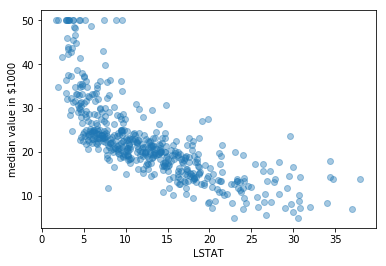

In [5]:
data = load_boston()
df = pd.DataFrame(data.data, columns=data.feature_names)

X = df.LSTAT.values.reshape((-1,1))
y = data.target.reshape((-1,1))
print("X shape: ", X.shape)
print("y shape: ", y.shape)

plt.scatter(X[:,0], y, alpha=0.4)
plt.xlabel('LSTAT')
plt.ylabel('median value in $1000')

plt.show()

## Exercise 1

Write the code for the functions specified below, using matrix/vector computation with NumPy. Note that each function requires only a few lines of code:

- computation of the cost function value
- computation of the gradient
- optimization of the cost function: application of the gradient descent technique
- computation of the prediction

Note also that the dataset is input to some of the functions in its original shape $N\times d$ while it is input in the extended shape $N \times (1+d)$ for the others 

In [6]:
# computation of the cost function value
def compute_cost(Xe, y, w):
    """
    Calculates  mean square error cost.

    :param Xe: design matrix
    :type Xe: np.ndarray(shape=(N, 1+d))
    :param y: regression targets
    :type y: np.ndarray(shape=(N, 1))
    :param w: weights
    :type w: np.array(shape=(1+d, 1))
    :return: cost
    :rtype: float
    """

    # START OF YOUR CODE:
    predictions = Xe @ w
    mse = mean_squared_error(y, predictions)
    J = 1/len(Xe) * mse 
    # END YOUR CODE

    return J

In [7]:
# computation of the gradient
def compute_wgrad(Xe, y, w):
    """
    Calculates gradient of J(w) with respect to w.

    :param Xe: design matrix
    :type Xe: np.ndarray(shape=(N, 1+d))
    :param y: regression targets
    :type y: np.ndarray(shape=(N, 1))
    :param w: weights
    :type w: np.array(shape=(1+d, 1))
    :return: gradient
    :rtype: np.array(shape=(1+d, 1))
    """

    # START OF YOUR CODE:
    N = len(Xe)
    d = len(Xe[0])
    lines = Xe[:, 1]
    y_hat = Xe @ w
    grad = [
            (y_hat - y).sum(),
            np.dot((y_hat - y)[:, 0], lines)
           ]
    grad = 2/N * np.asarray(grad, dtype=np.float64)
    grad = grad.reshape(len(grad), 1)
    # END YOUR CODE

    return grad

w = np.array([[20], [0]])
Xe = add_feature_ones(X)
g = compute_wgrad(Xe, y, w)
print(g)

[[-5.06561265]
 [32.60806719]]


The **batch gradient descent** algorithm

At each iteration (epoch), the whole dataset is used to update the weight vector. 
The function should iterate <tt>num_epochs</tt>
times and return the final weight vector as well as the *cost history*, a list containing the cost (E_in) computed before starting the iterations plus at the end of each iteration.
 
A left column of 1's should be add to the data matrix $X$

In [8]:
# optimization of the cost function:
# application of the gradient descent technique

def batch_gradient_descent(X, y, w, learning_rate=0.001, num_epochs=100):
    """
     Performs batch gradient descent optimization.

    :param X: design matrix
    :type X: np.ndarray(shape=(N, d))
    :param y: regression targets
    :type y: np.ndarray(shape=(N, 1))
    :param w: weights
    :type w: np.array(shape=(1+d, 1))
    :param learning_rate: learning rate
    :type learning_rate: float
    :param num_epochs: number of iterations
    :type num_iters: int
    :return: weights, cost history
    :rtype: np.array(shape=(1+d, 1)), list
    """
    
    # START OF YOUR CODE:
    Xe = add_feature_ones(X)
    w_current = w.copy()
    cost_history = [float('nan') for i in range(num_epochs)]
    for i in range (num_epochs):
        cost_history[i] = compute_cost(Xe, y, w_current)
        grad = compute_wgrad(Xe, y, w_current)
        aux = -1 * grad * learning_rate
        w_current = w_current + aux
    # END YOUR CODE

    return w_current, cost_history 

In [9]:
def compute_prediction(X, w):
    """
    Calculates the prediction over a set of observations X using
    the linear function characterized by the weight vector w.
    
    :param X: design matrix
    :type X: np.ndarray(shape=(N, d))
    :param w: weight vector
    :type w: np.ndarray(shape=(1+d, 1))
    :param y: regression prediction
    :type y: np.ndarray(shape=(N, 1))
    """
    
    # START OF YOUR CODE:
    Xe = add_feature_ones(X)
    prediction = Xe @ w
    # END YOUR CODE
        
    return prediction


## Exercise 2: Training

The code below uses the functions above.

Experiment varying the *learning rate*, the *initial weight vector*, and the *number of iterations*

Initial weight:
 [[40. ]
 [-0.1]]
MSE =  0.6675084807722351
Final weight:
 [[37.87758419]
 [-1.14959767]]
MSE =  0.08131955786680438


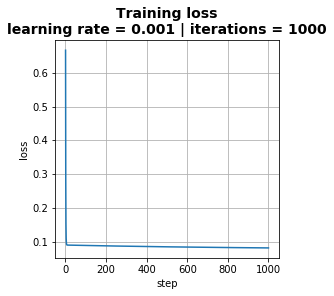

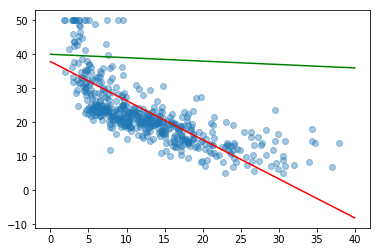

In [10]:
learning_rate = 0.001
initial_w = np.array([[40.0], [-0.1]])
print("Initial weight:\n", initial_w)
iterations = 1000

r_2 = compute_cost(Xe, y, initial_w)
print("MSE = ", r_2)

w, cost_history = batch_gradient_descent(X, y, initial_w, \
                                         learning_rate, iterations)

print("Final weight:\n", w)
r_2 = compute_cost(Xe, y, w)
print("MSE = ", r_2)

simple_step_plot(
    [cost_history], 'loss',
    'Training loss\nlearning rate = {} | iterations = {}'.format(learning_rate, iterations))

plt.scatter(X[:,0], y, alpha=0.4)
x_reg = np.linspace(0, 40, 100)
y_reg = initial_w[1]*x_reg + initial_w[0]
plt.plot(x_reg, y_reg, c='g')
y_reg = w[1]*x_reg + w[0]
plt.plot(x_reg, y_reg, c='r')
plt.show()

## Exercise 3:
*Concisely* write here the experiments you have performed and any interesting comments you have based on the experiments (max 10 lines):

- I tested different values for the initial w, learning_rate and iterations. At times I thought y code must be wrong, (see: lr=0.001, w=(-20,0), iter=1000), because the resulting line was weirdly placed. However, in that case tha seemed wrong, by increasing the iterations it eventually fixed. 
- The training loss always shows a straigth line downward in the initial point and I do not know an explanation. However, I found cases in which almost all the improvement is in the first step (lr=0.001, w=(-40, -0.1), iter=1000).
- Big values for leatning rate result in overflow. I find that weird but did not investigate



## Exercise 4: Comparison

- Use the normal equation code (analytical solution) of your EP2 to process the same dataset above.
- Print the final weight vector
- Compute the prediction using function <tt>compute_prediction()</tt> above
- Compute and print the R-squared metric
- Use the normal equation code (analytical solution) of your EP2 to process the same dataset above.
- Plot a graph with the examples and the function $\mathbf{w}^T\mathbf{x}$
- Add a text cell, and write any comments regarding what you have observed/learned by comparing the *batch gradient descent* and the analytical solution


In [28]:
# edited from pe02
def normal_equation_weights(X, y):
    """
    Calculates the weights of a linear function using the normal equation method.
    You should add into X a new column with 1s.

    :param X: design matrix
    :type X: np.ndarray(shape=(N, d))
    :param y: regression targets
    :type y: np.ndarray(shape=(N, 1))
    :return: weight vector
    :rtype: np.ndarray(shape=(d+1, 1))
    """
    
    # START OF YOUR CODE:
    Y = add_feature_ones(X)
    YT = Y.T
    Yaux = np.matmul(YT, Y)
    Yc = np.matmul(np.linalg.inv(Yaux), YT)
    w = np.matmul(Yc, y)
    w = np.array([[w[0][0]], [w[1][0]]])
    # END YOUR CODE

    return w

In [29]:
# Code to run and show results of the analytical solution
learning_rate = 0.001
iterations = 1000
initial_w = np.array([[40.0], [-0.1]])
print("Initial weight for linear regression: \n", initial_w)
print("Learning rate for linear regression: \n", learning_rate)
print("Number of iterations for linear regression: \n", iterations)
print("\n------------------------------------\n")

w_ANA = normal_equation_weights(X, y)
w_REG, cost_history = batch_gradient_descent(X, y, initial_w, \
                                         learning_rate, iterations)

print("Final weight LIN-ANA:\n", w_ANA)
pred_ANA = Xe @ w_ANA
r_2 = r_squared(y, pred_ANA)
print("r_squared metric LIN-ANA = ", r_2)

print("Final weight LIN-REG:\n", w_REG)
pred_REG = Xe @ w_REG
r_2 = r_squared(y, pred_REG)
print("r_squared metric LIN-REG = ", r_2)

Initial weight for linear regression: 
 [[40. ]
 [-0.1]]
Learning rate for linear regression: 
 0.001
Number of iterations for linear regression: 
 1000

------------------------------------

Final weight LIN-ANA:
 [[34.55384088]
 [-0.95004935]]
r_squared metric LIN-ANA =  0.5441462975864797
Final weight LIN-REG:
 [[37.87758419]
 [-1.14959767]]
r_squared metric LIN-REG =  0.5125809924363383


Initial weight for linear regression: 
 [[40. ]
 [-0.1]]
Learning rate for linear regression: 
 0.001
Number of iterations for linear regression: 
 100

------------------------------------

Final weight LIN-ANA:
 [[34.55384088]
 [-0.95004935]]
r_squared metric LIN-ANA =  0.5441462975864797
Final weight LIN-REG:
 [[39.67723476]
 [-1.25764369]]
r_squared metric LIN-REG =  0.46914469724317454


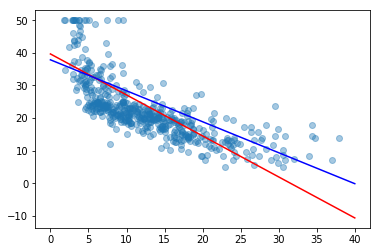

In [33]:
# Code to run and show results of the analytical solution
learning_rate = 0.001
iterations = 100
initial_w = np.array([[40.0], [-0.1]])
print("Initial weight for linear regression: \n", initial_w)
print("Learning rate for linear regression: \n", learning_rate)
print("Number of iterations for linear regression: \n", iterations)
print("\n------------------------------------\n")

w_ANA = normal_equation_weights(X, y)
w_REG, cost_history = batch_gradient_descent(X, y, initial_w, \
                                         learning_rate, iterations)

print("Final weight LIN-ANA:\n", w_ANA)
pred_ANA = Xe @ w_ANA
r_2 = r_squared(y, pred_ANA)
print("r_squared metric LIN-ANA = ", r_2)

print("Final weight LIN-REG:\n", w_REG)
pred_REG = Xe @ w_REG
r_2 = r_squared(y, pred_REG)
print("r_squared metric LIN-REG = ", r_2)

plt.scatter(X[:,0], y, alpha=0.4)
x_plot = np.linspace(0, 40, 100)
y_reg = w_REG[1]*x_plot + w_REG[0]
plt.plot(x_plot, y_reg, c='r')
y_ana = w_ANA[1]*x_plot + w[0]
plt.plot(x_plot, y_ana, c='b')
plt.show()


Your comments (max 10 lines) here:

- Both solutions were very close, as expected.
- Regression has, for large iteration numbers, smaller R_square. 

## Extras (no bonus, just for fun)

1. If you are curious, you may also implement the **stochastic gradient descent** algorithm and compare it with the batch version. Recal that in the stochastic version, only one example is used to compute the cost and update the weight vector. There will be two layers of iteration: one for iterating over the examples in the training set (example by example) -- one of these iterations correspond to an epoch; and a second one to iterate multiple times over the set (that is, the number os times you scan the whole set corresponds to the number of epochs)
2. You may also try different variables of the Boston Housing Prices dataset in $X$.